In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Load the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False)
base_model.trainable = False

# Preprocess the image
image_path = 'dog.jpeg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_tensor = tf.expand_dims(img_array, axis=0)  # Add batch dimension

# Pass the image tensor through the model
cnn_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
output = cnn_model(img_tensor)

print(output.shape)


In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set Metal as the default compute device
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Load ResNet50 without top layers
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',  # Or specify None if you don't want to use pre-trained weights
    input_shape=(224, 224, 3)  # Adjust input shape according to your needs
)
resnet50.trainable = False  # Freeze the weights of the ResNet50 base model

# Define additional layers
output = resnet50.output
output = tf.keras.layers.Reshape((-1, 2048))(output)  # Reshape the output to match the desired shape
output = tf.keras.layers.Dense(1280)(output)  # Add a dense layer to reduce dimensionality


In [ ]:
# Create the model
cnn_model = tf.keras.Model(inputs=resnet50.input, outputs=output)

# Load and preprocess the image
image_path = 'dog.jpeg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Preprocess input for ResNet50

# Process the image through the model
features = cnn_model.predict(tf.expand_dims(img_array, axis=0))

print(features.shape)  # Check the shape of the extracted features


---

# coreml implementation

In [ ]:
import coremltools as ct

In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import coremltools as ct
import numpy as np
import time
from PIL import Image

# Load the CoreML model
model = ct.models.MLModel('converted_model.mlpackage')

# Prepare input data (replace 'input_image.jpg' with your test image)
image = Image.open('cat.jpeg').resize((224, 224))
image = np.array(image) / 127.0 - 1.0
input_data = {'input_image': image}

# Perform inference and measure time
start_time = time.time()
output = model.predict(input_data)
inference_time = time.time() - start_time

# Print inference result
print("Inference result:", output)

# Print inference time
print("Inference time:", inference_time, "seconds")

In [ ]:
# Tested with TensorFlow 2.6.2
import tensorflow as tf
import coremltools as ct

tf_keras_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

# Pass in `tf.keras.Model` to the Unified Conversion API
mlmodel = ct.convert(tf_keras_model, convert_to="mlprogram", source="tensorflow")

# or save the keras model in SavedModel directory format and then convert
tf_keras_model.save('tf_keras_model')
mlmodel = ct.convert('tf_keras_model', convert_to="mlprogram")

# or load the model from a SavedModel and then convert
tf_keras_model = tf.keras.models.load_model('tf_keras_model')
mlmodel = ct.convert(tf_keras_model, convert_to="mlprogram")

# or save the keras model in HDF5 format and then convert
tf_keras_model.save('tf_keras_model.h5')
mlmodel = ct.convert('tf_keras_model.h5', convert_to="mlprogram")

In [ ]:
!pip install coremltools

In [ ]:
import coremltools as ct

saved_model_path = 'saved_model/'
tf.saved_model.save(cnn_model, saved_model_path)

# Convert the TensorFlow SavedModel to CoreML
model = ct.convert(saved_model_path)

model.save('converted_model.mlpackage')

In [ ]:
import tensorflow as tf

inputs = tf.constant([[1, 2, 0], [3, 0, 0], [4, 5, 6]])
tf.math.not_equal(inputs, 0)

---

In [1]:
from tensorflow.keras.applications import efficientnet as efn
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
anns_file_path = 'coco/annotations/instances_val2017.json'
images_dir = 'coco/images/val2017'

In [3]:
# open annotations file
with open(anns_file_path, 'r') as f:
    anns = json.loads(f.read())

In [4]:
# Load the annotations into a DataFrame
anns_df = pd.DataFrame(anns['annotations'])
anns_df.drop_duplicates(subset=['image_id'], inplace=True)
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419


In [5]:
len(anns_df)

4952

In [26]:
def add_zeros_and_extension(image_ids):
    # Convert image_ids to strings and add '.jpg' extension
    image_paths = [f'{str(image_id).zfill(12)}.jpg' for image_id in image_ids]
    return image_paths

anns_df['file_name'] = add_zeros_and_extension(anns_df['image_id'])
anns_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id,file_name
0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416....",702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,1768,000000289343.jpg
1,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427....",27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1773,000000061471.jpg
2,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347....",78969.31690,0,472375,"[124.71, 196.18, 372.85, 356.81]",18,2551,000000472375.jpg
3,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...",108316.66515,0,520301,"[112.71, 154.82, 367.29, 479.35]",18,3186,000000520301.jpg
4,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336....",75864.53530,0,579321,"[200.61, 89.65, 400.22, 251.02]",18,3419,000000579321.jpg


In [34]:
anns_df['file_name'] = anns_df['file_name'].astype(str)

In [45]:
!pwd

/Users/thilakcm/Downloads/UMD stuff/spring 2024/NLP/project/NLP641FinalProject


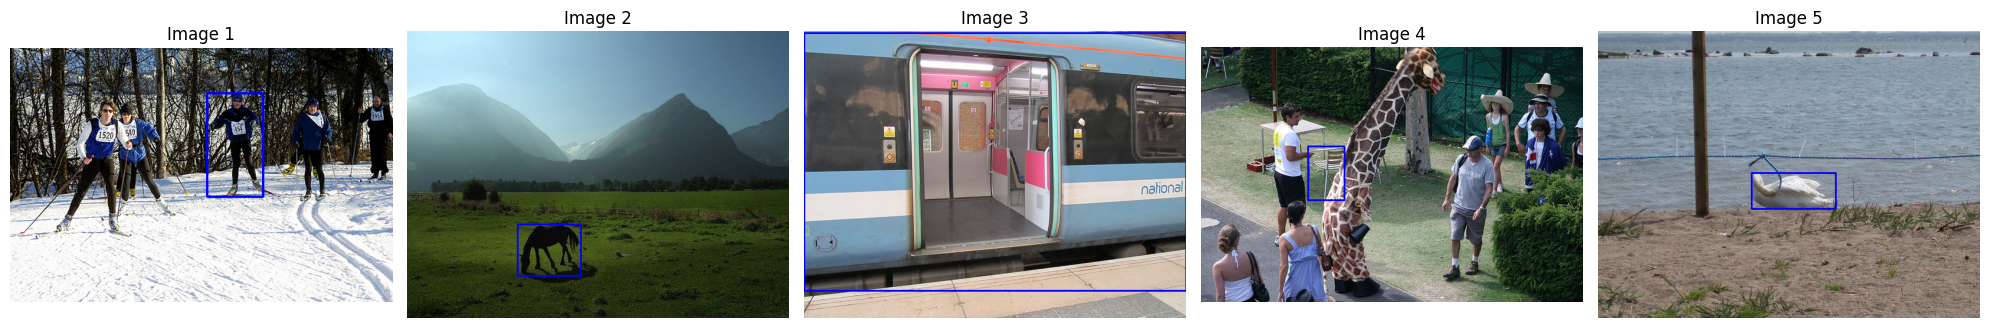

In [60]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Define the directory containing images
images_dir = "coco/images/val2017"

# Function to draw bounding boxes and display images
def draw_bounding_boxes(image_ids, anns_df, images_dir, num_images=5):
    # Select 5 random image IDs
    random_image_ids = random.sample(list(image_ids), num_images)
    
    # Create a subplot with 5 rows
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 6))

    # Iterate over the selected random image IDs
    for i, image_id in enumerate(random_image_ids):
        # Load the image
        image_path = os.path.join(images_dir, image_id)
        image = cv2.imread(image_path)

        # Get the bounding box coordinates
        bbox = anns_df.loc[anns_df['file_name'] == image_id, 'bbox'].values[0]
        bbox = [int(coord) for coord in bbox]
        x, y, w, h = bbox

        # Draw the bounding box on the image
        image_with_bbox = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Display the image with bounding box
        axes[i].imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function to draw bounding boxes for 5 random images
draw_bounding_boxes(anns_df['file_name'], anns_df, images_dir, num_images=5)


In [50]:
train_df

,segmentation,area,iscrowd,image_id,bbox,category_id,id,file_name
25043,"[[3.24, 297.84, 29.19, 295.68, 34.59, 474.05, ...",5289.66705,0,296222,"[1.08, 295.68, 33.51, 179.46]",62,380831,000000296222.jpg
33015,"[[110.45, 474.84, 123.87, 455.23, 120.77, 424....",2229.80130,0,498747,"[110.45, 417.03, 58.84, 57.81]",44,84985,000000498747.jpg
9050,"[[2.16, 388.31, 91.69, 369.98, 197.39, 350.56,...",31793.32750,0,578093,"[2.16, 230.83, 296.63, 157.48]",7,169678,000000578093.jpg
30,"[[360.49, 53.74, 347.96, 54.7, 327.72, 57.59, ...",3215.90305,0,226984,"[290.13, 9.4, 91.57, 48.19]",64,21865,000000226984.jpg
1629,"[[1.08, 321.11, 2.16, 473.2, 146.7, 473.2, 166...",52942.60100,0,431140,"[1.08, 147.45, 266.43, 325.75]",70,1093281,000000431140.jpg
...,...,...,...,...,...,...,...,...
29679,"[[423.68, 56.2, 427.93, 82.52, 427.93, 100.35,...",38151.79820,0,477805,"[383.78, 12.06, 201.19, 374.37]",1,564585,000000477805.jpg
1679,"[[239.28, 303.42, 229.19, 312.07, 221.98, 320....",9723.19970,0,206271,"[214.77, 293.33, 99.46, 136.94]",70,1094975,000000206271.jpg
20613,"[[128.36, 137.89, 174.74, 162.7, 198.47, 173.4...",109062.90950,0,255747,"[100.31, 85.03, 458.43, 326.84]",54,308854,000000255747.jpg
24952,"[[359.94, 265.65, 439.26, 234.22, 440.01, 260....",2644.07805,0,497344,"[359.94, 234.22, 80.07, 69.6]",77,324057,000000497344.jpg


In [59]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (299, 299)
batch_size = 64
input_shape = (299, 299)

# Define data generators
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_shape[:2])
    image = preprocess_input(image) 
    return image, label

# Convert image paths to strings
anns_df['file_name'] = anns_df['file_name'].astype(str)

# Perform train-test split
train_df, val_df = train_test_split(anns_df, test_size=0.1, random_state=42)

# Convert image paths to strings
train_df['file_name'] = train_df['file_name'].astype(str)
val_df['file_name'] = val_df['file_name'].astype(str)

# Define train and validation datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_name'], train_df['category_id']))
train_ds = train_ds.map(preprocess_image).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_name'], val_df['category_id']))
val_ds = val_ds.map(preprocess_image).batch(batch_size)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import Huber

def get_cnn_model():
    # Load pre-trained EfficientNetB0 model
    base_model = EfficientNetB0(
        input_shape=(*input_shape, 3), include_top=False, weights="imagenet")
    
    # Freeze feature extractor layers
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    # Reshape the output to match the desired shape
    base_model_out = layers.Reshape((-1, 1280))(base_model.output)
    
    # Define the model
    cnn_model = models.Model(base_model.input, base_model_out)
    return cnn_model


# Get the CNN model
cnn_model = get_cnn_model()

# Compile the model with Smooth L1 Loss
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss=Huber(),
                  metrics=['accuracy'])

# Train the model on your dataset
history = cnn_model.fit(train_ds,
                        epochs=10,
                        validation_data=val_ds)

# Save the model
cnn_model.save('fine_tuned_efficientnet.h5')

Epoch 1/10


2024-05-10 09:58:55.152432: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000498747.jpg; No such file or directory
2024-05-10 09:58:55.152456: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000563603.jpg; No such file or directory
2024-05-10 09:58:55.152461: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000578093.jpg; No such file or directory
2024-05-10 09:58:55.152483: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000226984.jpg; No such file or directory
2024-05-10 09:58:55.152509: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: 000000365655.jpg; No such file or directory
2024-05-10 09:58:55.152516: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed a

NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) NOT_FOUND:  000000296222.jpg; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/functional_11_1/block6d_drop_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_140]]
  (1) NOT_FOUND:  000000296222.jpg; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_103914]

In [ ]:
num_train_images = len(images_dir)
print("Number of training images:", num_train_images)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input


In [ ]:
# Define paths
anns_file_path = 'coco/annotations/instances_val2017.json'
images_dir = 'coco/images/val2017'

# Load annotations
with open(anns_file_path, 'r') as f:
    anns = json.load(f)

# Load the annotations into a DataFrame
anns_df = pd.DataFrame(anns['annotations'])


In [ ]:
# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust according to your input image size
num_classes = 80  # Number of classes in COCO dataset


In [ ]:
# Load images and corresponding labels
image_paths = []
labels = []
for index, row in anns_df.iterrows():
    image_id = row['image_id']
    image_path = os.path.join(images_dir, f'{image_id:012d}.jpg')
    image_paths.append(image_path)
    labels.append(row['category_id'])


In [ ]:
print("Number of images:", len(image_paths))

In [ ]:
import os

# Define the path to the val2017 folder
val_folder_path = 'coco/images/val2017'

# Count the number of files in the val2017 folder
num_images_val_folder = len(os.listdir(val_folder_path))

print("Number of images in val2017 folder:", num_images_val_folder)


In [ ]:
import os

# Define the path to the val2017 folder
val_folder_path = 'coco/images/val2017'

# Get a list of all image filenames in the val2017 folder
val_image_filenames = os.listdir(val_folder_path)

# Convert filenames to full paths
val_image_paths = [os.path.join(val_folder_path, filename) for filename in val_image_filenames]

# Find the difference between the image paths in your dataset and the actual files in the val2017 folder
missing_images = set(val_image_paths) - set(image_paths)

# Print the number of missing images
print("Number of missing images:", len(missing_images))


In [ ]:
import os
import json

# Define paths
anns_file_path = 'coco/annotations/instances_val2017.json'
images_dir = 'coco/images/val2017'

# Load annotations
with open(anns_file_path, 'r') as f:
    anns = json.load(f)

# Get the list of image paths in the val2017 folder
val_image_paths = [os.path.join(images_dir, image_id) for image_id in os.listdir(images_dir)]

# Filter image paths in the annotations file to include only those present in val2017 folder
filtered_image_paths = [image_path for image_path in val_image_paths if image_path in [image['file_name'] for image in anns['images']]]

# Check the length of the filtered image paths list
print("Number of images in annotations file after filtering:", len(filtered_image_paths))


In [ ]:
# Load categories mapping
categories = {category['id']: category['name'] for category in anns['categories']}


In [ ]:
# Split data into train and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
# Define data generators
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_shape[:2])
    image = preprocess_input(image) 
    return image, label

batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_ds = train_ds.map(preprocess_image).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_ds = val_ds.map(preprocess_image).batch(batch_size)


In [ ]:
# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

# Unfreeze the last 10 layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True


In [ ]:
# Compile the model
base_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = base_model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)


In [ ]:
# Save the model
model.save('efficientnet_coco_finetuned.h5')
